In [ ]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import FormatStrFormatter, MultipleLocator
from matplotlib.lines import Line2D
from matplotlib.patches import Ellipse
from matplotlib import transforms
import re
import math

# High DPI for publication
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300

# ---- Overall Font Style ----
matplotlib.rcParams['font.family'] = 'sans-serif'
matplotlib.rcParams['font.sans-serif'] = ['DejaVu Serif', 'Helvetica', 'Arial', 'DejaVu Sans']
matplotlib.rcParams['svg.fonttype'] = 'path' # 'none'  # keep text as text in SVG
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype']  = 42
matplotlib.rcParams['mathtext.fontset'] = 'cm' # TeX Computer Modern 느낌

In [ ]:
# Freeze method colors
method_name_colors = {
    "TimelyFreeze": "#1977f3",
    "No Freezing": "#000000",
    "TimelyFreeze+APF": "#64a5fa",
    "APF": "#757575",
    "TimelyFreeze+AutoFreeze": "#b2d3ff",
    "AutoFreeze": "#C9C9C9",
}

In [ ]:
def plt_save_fig(plt, save_file):
    '''Save the current matplotlib figure with a specified name or default naming convention.'''
    plt.savefig(save_file)
    print("Saved to:", save_file)
    return 

In [ ]:
def plot_acc_vs_throughput(
    df,
    pipelines=("GPipe", "1F1B", "Interleaved 1F1B"),
    method_name_colors: dict={
            "TimelyFreeze": "#1977f3",
            "No Freezing": "#000000",
            "TimelyFreeze+APF": "#64a5fa",
            "APF": "#757575",
            "TimelyFreeze+AutoFreeze": "#b2d3ff",
            "AutoFreeze": "#C9C9C9",
        },
    marker_type: dict={
            "No Freezing": ("s", 40),
            "APF": ("D", 35),
            "AutoFreeze": ("^", 35),
            "TimelyFreeze": ("o", 45),
            "TimelyFreeze+APF": ("D", 35),
            "TimelyFreeze+AutoFreeze": ("^", 35),
        },
    legend_markersize: int=5,
    title_col="title",
    acc_col="Acc Gain",
    thr_col="Throughput Gain",
    method_col="Method",
    pipeline_col="Pipeline",
    figsize=(8, 3.2),
    wspace=0.05,
    x_pad=0.1,
    y_pad=0.5,
    xticks_count=5,
    y_min=0,
    y_major_step=10,
    xlabel="Accuracy Gain (%p)",
    ylabel="Throughput Gain (%)",
    show_xlabel_center_only=True,
    guideline_levels=(0.4**2, 0.55**2, 0.7**2, 0.85**2, 1.0**2, 1.15**2, 1.3**2),
    guideline_margin_y=0.5,
    show_legend=True,
    legend_ncol=3,
    legend_bbox=(0.5, 0.16),
    legend_handletextpad=0.2,
    legend_labelspacing=0.6,
    legend_columnspacing=2,
    legend_location='upper center',
    bottom_margin=0.32,
    left_margin=0.06,
    right_margin=0.04,
    title_fontsize=14,
    fontsize=12,
    save=True,
    out_name=None,
 ):
    # Figure and axes
    num_axes = len(pipelines)
    fig, axes = plt.subplots(1, num_axes, figsize=figsize, sharex=True, sharey=True, gridspec_kw={'wspace': wspace})
    if num_axes == 1:
        axes = [axes]

    # Limits from data
    title = str(df[title_col].iloc[0]) if title_col in df.columns else ""
    x_min = float(df[acc_col].min())
    x_max = float(df[acc_col].max())
    y_max = float(df[thr_col].max())

    # Plot points
    for i, (ax, pipeline) in enumerate(zip(axes, pipelines)):
        sub = df[df[pipeline_col] == pipeline].copy()
        sub["_method_base"] = sub[method_col].apply(lambda val: re.sub(r"\([^)]*\)", "", str(val)))
        for _, row in sub.iterrows():
            method_str = row["_method_base"]
            color = method_name_colors.get(method_str, "gray")
            marker, marker_size = marker_type.get(method_str, ("o", 40))
            ax.scatter(row[acc_col], max(y_pad, row[thr_col]),
                       color=color, s=marker_size, marker=marker, linewidth=0.4)
    
    # XY Labels and Title
    if num_axes > 1:
        for ax, pipeline in zip(axes, pipelines):
            ax.set_title(pipeline, fontsize=title_fontsize)
            ax.set_axisbelow(True)
    if show_xlabel_center_only:
        if show_legend:
            xlabel_y = max(0.02, bottom_margin - 0.15)  # keep label below panels but above legend
        else:
            xlabel_y = 0.12  # keep label below panels but above legend
        xlabel_x = left_margin + (1 - left_margin - right_margin) / 2
        fig.supxlabel(xlabel, fontsize=fontsize, x=xlabel_x, y=xlabel_y)
    else:
        for ax in axes:
            ax.set_xlabel(xlabel, fontsize=fontsize)
    axes[0].set_ylabel(ylabel, fontsize=fontsize)

    # Axes box and limits
    for ax in axes:
        ax.set_xlim(x_min - x_pad, x_max + x_pad)
        ax.set_ylim(y_min, y_max + y_pad)
        if hasattr(ax, 'set_box_aspect'):
            ax.set_box_aspect(1)
        else:
            ax.set_aspect('equal', adjustable='box')

    # Ticks: x aligned to box edges; y every 10 and align top to a multiple of step
    x0, x1 = axes[0].get_xlim()
    y0, y1 = axes[0].get_ylim()
    xticks = np.linspace(x0, x1, xticks_count)
    y1_rounded = math.ceil(y1 / y_major_step) * y_major_step
    for ax in axes:
        ax.set_xticks(xticks)
        ax.tick_params(axis='both', which='major', labelsize=fontsize)
        ax.set_ylim(y0, y1_rounded)
        ax.yaxis.set_major_locator(MultipleLocator(y_major_step))
        ax.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))

    # Pareto-like normalized elliptical guideline lines
    dx = x_max - x_min
    dy = y_max - y_min
    theta = np.linspace(0, 2*np.pi, 400)
    k_levels = np.array(guideline_levels)
    for k in k_levels:
        r = np.sqrt(k)
        x_curve = x_min + dx * r * np.cos(theta)
        y_curve = y_min + dy * r * np.sin(theta)
        mask = (y_curve >= (y_min + guideline_margin_y)) & (y_curve <= (y1_rounded + y_pad + guideline_margin_y))
        for ax in axes:
            ax.plot(x_curve[mask], y_curve[mask], color="#cfcfcf", linestyle="--", linewidth=0.6, zorder=0)


    # Legend (optional)
    if show_legend:
        handles = [
            Line2D([0], [0], marker=marker_type.get(method, 'o')[0], color='w', label=method,
                   markerfacecolor=color, markeredgecolor=color, markersize=legend_markersize)
            for method, color in method_name_colors.items()
        ]
        fig.legend(handles=handles, loc=legend_location, ncol=legend_ncol, frameon=False,
                   bbox_to_anchor=legend_bbox, fontsize=fontsize,
                   handletextpad=legend_handletextpad, labelspacing=legend_labelspacing, columnspacing=legend_columnspacing) 

    # Space for legend (fixed)
    fig.subplots_adjust(left=left_margin, right=1-right_margin, bottom=bottom_margin)

    # Save
    if save:
        out = out_name or (f"{title}_result_pareto.pdf" if title else "accuracy_vs_throughput.pdf")
        plt_save_fig(plt, out)
    return plt


In [ ]:
# Build the dataset from the user table
data = {
    "Pipeline": [
        "GPipe","GPipe","GPipe","GPipe","GPipe","GPipe",
        "1F1B","1F1B","1F1B","1F1B","1F1B","1F1B",
        "Interleaved 1F1B","Interleaved 1F1B","Interleaved 1F1B","Interleaved 1F1B","Interleaved 1F1B","Interleaved 1F1B"
    ],
    "Method": [
        "No Freezing","APF(0.005)","AutoFreeze(80)","TimelyFreeze(0.7)","TimelyFreeze(0.7)+APF(0.005)","TimelyFreeze(0.7)+AutoFreeze(80)",
        "No Freezing","APF(0.003)","AutoFreeze(80)","TimelyFreeze(0.7)","TimelyFreeze(0.7)+APF(0.003)","TimelyFreeze(0.7)+AutoFreeze(80)",
        "No Freezing","APF(0.01)","AutoFreeze(80)","TimelyFreeze(0.7)","TimelyFreeze(0.7)+APF(0.01)","TimelyFreeze(0.7)+AutoFreeze(80)"
    ],
    "Acc Gain": [
        4.14,3.69,3.73,3.17,3.28,3.40,
        4.00,3.39,3.33,4.37,4.42,3.44,
        4.01,3.30,2.98,3.37,3.54,3.52
    ],
    "Throughput Gain": [
        0,33.51,28.59,18.37,18.69,34.80,
        0,33.24,26.54,29.87,30.95,31.14,
        0,28.34,23.09,28.05,27.09,28.07
    ]
}

# Call with current data
plot_acc_vs_throughput(pd.DataFrame(data), pipelines=("GPipe","1F1B","Interleaved 1F1B"), \
    method_name_colors=method_name_colors, show_legend=True, \
        save=True, out_name="llama8b_result_pareto.svg")

plot_acc_vs_throughput(pd.DataFrame(data), pipelines=("GPipe","1F1B","Interleaved 1F1B"), \
                        method_name_colors={
                            "TimelyFreeze": "#000000",
                            "No Freezing": "#757575",
                            "TimelyFreeze+APF": "#1977f3",
                            "APF": "#b2d3ff",
                            "TimelyFreeze+AutoFreeze": "#2ab600",
                            "AutoFreeze": "#ade29d",
                        }, \
                        marker_type={
                            "No Freezing": ("o", 90),
                            "APF": ("o", 90),
                            "AutoFreeze": ("o", 90),
                            "TimelyFreeze": ("D", 80),
                            "TimelyFreeze+APF": ("D", 80),
                            "TimelyFreeze+AutoFreeze": ("D", 80),
                        },
                        legend_markersize=8, show_legend=True, figsize=(8,4), bottom_margin=0.44, legend_bbox=(0.5, 0.3), 
                        title_fontsize=16, fontsize=13.5, 
                        save=True, out_name="llama8b_result_pareto_for_slide.pdf")

In [ ]:
# Build the dataset from the user table
data = {
    "Pipeline": [
        "GPipe","GPipe","GPipe","GPipe","GPipe","GPipe",
        "1F1B","1F1B","1F1B","1F1B","1F1B","1F1B",
        "Interleaved 1F1B","Interleaved 1F1B","Interleaved 1F1B",
        "Interleaved 1F1B","Interleaved 1F1B","Interleaved 1F1B"
    ],
    "Method": [
        "No Freezing","APF(0.05)","AutoFreeze(80)",
        "TimelyFreeze(0.8)","TimelyFreeze(0.8)+APF(0.05)","TimelyFreeze(0.8)+AutoFreeze(80)",
        "No Freezing","APF(0.01)","AutoFreeze(80)",
        "TimelyFreeze(0.8)","TimelyFreeze(0.8)+APF(0.01)","TimelyFreeze(0.8)+AutoFreeze(80)",
        "No Freezing","APF(0.03)","AutoFreeze(80)",
        "TimelyFreeze(0.8)","TimelyFreeze(0.8)+APF(0.03)","TimelyFreeze(0.8)+AutoFreeze(80)"
    ],
    "Acc Gain": [
        2.06,0.69,0.71,0.92,0.75,0.80,
        1.67,0.94,0.44,1.79,2.11,1.27,
        1.12,0.57,0.53,0.58,0.90,0.29
    ],
    "Throughput Gain": [
        0,34.79,8.03,40.34,41.21,39.64,
        0,12.40,3.87,20.66,18.18,22.10,
        0,22.66,4.42,18.29,19.84,19.16
    ]
}
marker_type={
    "No Freezing": ("o", 90),
    "APF": ("o", 90),
    "AutoFreeze": ("o", 90),
    "TimelyFreeze": ("D", 80),
    "TimelyFreeze+APF": ("D", 80),
    "TimelyFreeze+AutoFreeze": ("D", 80),
}

# Call with current data
plot_acc_vs_throughput(pd.DataFrame(data), pipelines=("GPipe","1F1B","Interleaved 1F1B"), \
    method_name_colors=method_name_colors, figsize=(9,4), show_legend=True, 
        legend_markersize=8, title_fontsize=18, fontsize=16, marker_type=marker_type,
            save=True, out_name="llama1b_result_pareto.pdf")

plot_acc_vs_throughput(pd.DataFrame(data), pipelines=("GPipe","1F1B","Interleaved 1F1B"), \
    method_name_colors=method_name_colors, figsize=(9,4), show_legend=False, 
        legend_markersize=8, title_fontsize=18, fontsize=16, marker_type=marker_type,
            save=True, out_name="llama1b_result_pareto_wo_legend.pdf")

# # Call with current data
# plot_acc_vs_throughput(pd.DataFrame(data), pipelines=("GPipe","1F1B","Interleaved 1F1B"), \
#     method_name_colors=method_name_colors, show_legend=True, \
#         save=True, out_name="llama1b_result_pareto.pdf")

# plot_acc_vs_throughput(pd.DataFrame(data), pipelines=("GPipe","1F1B","Interleaved 1F1B"), \
#     method_name_colors=method_name_colors, show_legend=False, \
#         save=True, out_name="llama1b_result_pareto_wo_legend.pdf")

plot_acc_vs_throughput(pd.DataFrame(data), pipelines=("GPipe","1F1B","Interleaved 1F1B"), \
                        method_name_colors={
                            "TimelyFreeze": "#000000",
                            "No Freezing": "#757575",
                            "TimelyFreeze+APF": "#1977f3",
                            "APF": "#b2d3ff",
                            "TimelyFreeze+AutoFreeze": "#2ab600",
                            "AutoFreeze": "#ade29d",
                        }, \
                        marker_type={
                            "No Freezing": ("o", 90),
                            "APF": ("o", 90),
                            "AutoFreeze": ("o", 90),
                            "TimelyFreeze": ("D", 80),
                            "TimelyFreeze+APF": ("D", 80),
                            "TimelyFreeze+AutoFreeze": ("D", 80),
                        },
                        legend_markersize=8, show_legend=False, figsize=(8,4), bottom_margin=0.44, legend_bbox=(0.5, 0.), 
                        title_fontsize=16, fontsize=13.5, 
                        save=True, out_name="llama1b_result_pareto_wo_legend_for_slide.pdf")

In [ ]:
# Build the dataset from the user table
data = {
    "Pipeline": [
        "GPipe","GPipe","GPipe","GPipe","GPipe","GPipe",
        "1F1B","1F1B","1F1B","1F1B","1F1B","1F1B",
        "Interleaved 1F1B","Interleaved 1F1B","Interleaved 1F1B",
        "Interleaved 1F1B","Interleaved 1F1B","Interleaved 1F1B",
        "ZBV", "ZBV", "ZBV", "ZBV", "ZBV", "ZBV"
    ],
    "Method": [
        "No Freezing","APF(0.01)","AutoFreeze(80)",
        "TimelyFreeze(0.8)","TimelyFreeze(0.8)+APF(0.01)","TimelyFreeze(0.8)+AutoFreeze(80)",
        "No Freezing","APF(0.01)","AutoFreeze(80)",
        "TimelyFreeze(0.8)","TimelyFreeze(0.8)+APF(0.01)","TimelyFreeze(0.8)+AutoFreeze(80)",
        "No Freezing","APF(0.01)","AutoFreeze(80)",
        "TimelyFreeze(0.8)","TimelyFreeze(0.8)+APF(0.01)","TimelyFreeze(0.8)+AutoFreeze(80)",
        "No Freezing","APF(0.01)","AutoFreeze(80)",
        "TimelyFreeze(0.8)","TimelyFreeze(0.8)+APF(0.01)","TimelyFreeze(0.8)+AutoFreeze(80)",
    ],
    "Acc Gain": [
        2.17, 0.96, 1.09, 2.00, 1.08, 0.96,
        1.26, 0.79, -1.16, 0.68, 0.27, -0.10,
        1.38, 0.87, -1.10, 0.06, 0.22, 1.07,
        1.70, 0.64, 0.20, 1.90, 0.75, 0.27,
    ],
    "Throughput Gain": [
        0, 17.62, 10.69, 27.13, 27.12, 26.84, 
        0, 15.09, 6.52, 29.19, 28.10, 28.52, 
        0, 9.82, 2.29, 21.83, 20.09, 21.68, 
        0, 28.93, 6.06, 29.83, 27.65, 29.27,
    ]
}

marker_type={
    "No Freezing": ("o", 90),
    "APF": ("o", 90),
    "AutoFreeze": ("o", 90),
    "TimelyFreeze": ("D", 80),
    "TimelyFreeze+APF": ("D", 80),
    "TimelyFreeze+AutoFreeze": ("D", 80),
}

# Call with current data
plot_acc_vs_throughput(pd.DataFrame(data), pipelines=("GPipe","1F1B","Interleaved 1F1B", "ZBV"), \
    method_name_colors=method_name_colors, figsize=(12,4), show_legend=True, 
        legend_markersize=8, title_fontsize=18, fontsize=16, marker_type=marker_type,
            save=True, out_name="llama1b_result_pareto_1227.pdf")

plot_acc_vs_throughput(pd.DataFrame(data), pipelines=("GPipe","1F1B","Interleaved 1F1B", "ZBV"), \
    method_name_colors=method_name_colors, figsize=(12,4), show_legend=False, 
        legend_markersize=8, title_fontsize=18, fontsize=16, marker_type=marker_type,
            save=True, out_name="llama1b_result_pareto_wo_legend_1227.pdf")

plot_acc_vs_throughput(pd.DataFrame(data), pipelines=("GPipe","1F1B","Interleaved 1F1B", "ZBV"), \
                        method_name_colors={
                            "TimelyFreeze": "#000000",
                            "No Freezing": "#757575",
                            "TimelyFreeze+APF": "#1977f3",
                            "APF": "#b2d3ff",
                            "TimelyFreeze+AutoFreeze": "#2ab600",
                            "AutoFreeze": "#ade29d",
                        }, \
                        marker_type=marker_type,
                        legend_markersize=8, show_legend=False, figsize=(10,4), bottom_margin=0.44, legend_bbox=(0.5, 0.), 
                        title_fontsize=16, fontsize=13.5, 
                        save=True, out_name="llama1b_result_pareto_wo_legend_for_slide_1227.pdf")

In [ ]:
# Build the dataset from the user table
data = {
    "Pipeline": [
        "GPipe","GPipe","GPipe","GPipe","GPipe","GPipe",
        "1F1B","1F1B","1F1B","1F1B","1F1B","1F1B",
        "Interleaved 1F1B","Interleaved 1F1B","Interleaved 1F1B",
        "Interleaved 1F1B","Interleaved 1F1B","Interleaved 1F1B",
        "ZBV", "ZBV", "ZBV", "ZBV", "ZBV", "ZBV"
    ],
    "Method": [
        "No Freezing","APF(0.01)","AutoFreeze(80)",
        "TimelyFreeze(0.8)","TimelyFreeze(0.8)+APF(0.01)","TimelyFreeze(0.8)+AutoFreeze(80)",
        "No Freezing","APF(0.01)","AutoFreeze(80)",
        "TimelyFreeze(0.8)","TimelyFreeze(0.8)+APF(0.01)","TimelyFreeze(0.8)+AutoFreeze(80)",
        "No Freezing","APF(0.01)","AutoFreeze(80)",
        "TimelyFreeze(0.8)","TimelyFreeze(0.8)+APF(0.01)","TimelyFreeze(0.8)+AutoFreeze(80)",
        "No Freezing","APF(0.01)","AutoFreeze(80)",
        "TimelyFreeze(0.8)","TimelyFreeze(0.8)+APF(0.01)","TimelyFreeze(0.8)+AutoFreeze(80)",
    ],
    "Acc Gain": [
        1.78, 0.93, 0.86, 1.71, 1.25, 1.46, 
        0.99, 0.81, -0.42, 1.43, 0.76, 0.16, 
        1.49, 0.80, -0.67, 0.59, 0.43, 1.21, 
        1.65, 0.66, 0.40, 1.03, 0.23, 0.67, 
    ],
    "Throughput Gain": [
        0, 17.49, 8.20, 26.64, 27.21, 26.47, 
        0, 14.98, 6.60, 29.44, 28.09, 28.42, 
        0, 11.24, 4.60, 22.87, 21.73, 23.04, 
        0, 24.29, 4.85, 25.01, 23.12, 24.68, 
    ]
}
method_name_colors_transparent={
            "TimelyFreeze": "#005acfd1",
            "No Freezing": "#000000d1",
            "TimelyFreeze+APF": "#388dfcb7",
            "APF": "#55555594",
            "TimelyFreeze+AutoFreeze": "#89bcffbe",
            "AutoFreeze": "#b6b5b5ae",
        }

marker_type={
    "No Freezing": ("o", 250),
    "APF": ("o", 250),
    "AutoFreeze": ("o", 250),
    "TimelyFreeze": ("D", 200),
    "TimelyFreeze+APF": ("D", 200),
    "TimelyFreeze+AutoFreeze": ("D", 200),
}

# Call with current data
plot_acc_vs_throughput(pd.DataFrame(data), pipelines=("GPipe","1F1B","Interleaved 1F1B", "ZBV"), \
    method_name_colors=method_name_colors_transparent, figsize=(12,4.6), show_legend=True, 
        legend_markersize=10, title_fontsize=19, fontsize=18, marker_type=marker_type,
            xticks_count=4,
            legend_bbox=(0.5, 0.21), bottom_margin=0.38, right_margin=0.03,
                save=True, out_name="llama1b_result_pareto_42_11_22.pdf")

plt = plot_acc_vs_throughput(pd.DataFrame(data), pipelines=("GPipe","1F1B","Interleaved 1F1B", "ZBV"), \
    method_name_colors=method_name_colors_transparent, figsize=(12,3.9), show_legend=False, 
        legend_markersize=8, title_fontsize=19, fontsize=18, marker_type=marker_type,
        xticks_count=4,
            bottom_margin=0.3, right_margin=0.03,
                save=True, out_name="llama1b_result_pareto_wo_legend_42_11_22.pdf")

In [ ]:
def draw_arrow(
    plt, 
    data,
    pipelines=("GPipe","1F1B","Interleaved 1F1B", "ZBV"),
    colors=['#757575', '#C0C0C0'], 
    arrowstyle='-|>',
    arrow_alpha=0.6,
    arrow_width=2,
    arrowline_style='dotted',
    save=True,
    save_file="accuracy_vs_throughput_with_arrows.pdf"):
    
    fig = plt.gcf()
    df = pd.DataFrame(data)

    for ax, pipeline in zip(fig.axes, pipelines):
        sub = df[df["Pipeline"] == pipeline].copy()
        sub["_method_base"] = sub["Method"].apply(lambda val: re.sub(r"\([^)]*\)", "", str(val)))
        
        # Get coordinates for each method
        coords = {}
        for _, row in sub.iterrows():
            method = row["_method_base"]
            coords[method] = (row["Acc Gain"], max(0.5, row["Throughput Gain"]))
        
        # Draw arrow from APF to TimelyFreeze+APF
        if "APF" in coords and "TimelyFreeze+APF" in coords:
            x1, y1 = coords["APF"]
            x2, y2 = coords["TimelyFreeze+APF"]
            if x1 <= x2 and y1 <= y2:  # Only draw if the arrow goes up/right
                ax.annotate('', xy=(x2, y2), xytext=(x1, y1),
                    arrowprops=dict(arrowstyle=arrowstyle, color=colors[0], lw=arrow_width, alpha=arrow_alpha, linestyle=arrowline_style))
        
        # Draw arrow from AutoFreeze to TimelyFreeze+AutoFreeze
        if "AutoFreeze" in coords and "TimelyFreeze+AutoFreeze" in coords:
            x1, y1 = coords["AutoFreeze"]
            x2, y2 = coords["TimelyFreeze+AutoFreeze"]
            if x1 <= x2 and y1 <= y2:  # Only draw if the arrow goes up/right
                ax.annotate('', xy=(x2, y2), xytext=(x1, y1),
                    arrowprops=dict(arrowstyle=arrowstyle, color=colors[1], lw=arrow_width, alpha=arrow_alpha, linestyle=arrowline_style))

    if save:
        plt_save_fig(plt, save_file)
    return plt


In [ ]:
marker_type={
    "No Freezing": ("o", 250),
    "APF": ("o", 250),
    "AutoFreeze": ("o", 250),
    "TimelyFreeze": ("D", 200),
    "TimelyFreeze+APF": ("D", 200),
    "TimelyFreeze+AutoFreeze": ("D", 200),
}
# method_name_colors={
#     "No Freezing": "#000000d2",
#     "TimelyFreeze": "#1475f5d2", 
#     "APF": "#43d9ecd2", 
#     "AutoFreeze": "#7575fdd2",  # 76bdfa
# }
# method_name_colors_transparent={
#         "TimelyFreeze": "#1475f5d2", 
#         "No Freezing": "#000000d2",
#         "TimelyFreeze+APF": "#43d9ecd2",  # "#388dfcb7",
#         "APF": "#6daeb7d2",
#         "TimelyFreeze+AutoFreeze": "#7575fdd2", # "#89bcffbe",
#         "AutoFreeze": "#7777b7d2",
#     }

# Add arrows to the current plot from CELL INDEX 7
plt = plot_acc_vs_throughput(pd.DataFrame(data), pipelines=("GPipe","1F1B","Interleaved 1F1B", "ZBV"), \
    method_name_colors=method_name_colors_transparent, figsize=(12,3.9), show_legend=False, 
        legend_markersize=8, title_fontsize=19, fontsize=18, marker_type=marker_type,
        xticks_count=4,
            bottom_margin=0.3, right_margin=0.03, save=False)

draw_arrow(
    plt,
    data,
    pipelines=("GPipe","1F1B","Interleaved 1F1B", "ZBV"),
    colors=['#757575', "#9C9C9C"], 
    # colors=['#1977f3', '#64a5fa'],
    arrowstyle='-|>',
    arrow_alpha=0.7,
    arrow_width=2,
    arrowline_style='dotted',
    save=True,
    save_file="llama1b_result_pareto_with_arrows_42_11_22.pdf"
)

plt = plot_acc_vs_throughput(pd.DataFrame(data), pipelines=("GPipe","1F1B","Interleaved 1F1B", "ZBV"), \
    method_name_colors=method_name_colors_transparent, figsize=(12,4.6), show_legend=True, 
        legend_markersize=10, title_fontsize=19, fontsize=18, marker_type=marker_type,
            xticks_count=4,
            legend_bbox=(0.5, 0.21), bottom_margin=0.38, right_margin=0.03,
                save=False)
draw_arrow(
    plt,
    data,
    pipelines=("GPipe","1F1B","Interleaved 1F1B", "ZBV"),
    colors=['#757575', "#9C9C9C"], 
    # colors=['#1977f3', '#64a5fa'],
    arrowstyle='-|>',
    arrow_alpha=0.7,
    arrow_width=2,
    arrowline_style='dotted',
    save=True,
    save_file="llama1b_result_pareto_with_arrows_42_11_22_legend.pdf"
)

In [ ]:
# Build the dataset from the user table
data = {
    "Pipeline": [
        "GPipe","GPipe","GPipe","GPipe","GPipe","GPipe",
        "1F1B","1F1B","1F1B","1F1B","1F1B","1F1B",
        "Interleaved 1F1B","Interleaved 1F1B","Interleaved 1F1B",
        "Interleaved 1F1B","Interleaved 1F1B","Interleaved 1F1B",
        "ZBV", "ZBV", "ZBV", "ZBV", "ZBV", "ZBV"
    ],
    "Method": [
        "No Freezing","APF(1e-4)","AutoFreeze(80)",
        "TimelyFreeze(0.8)","TimelyFreeze(0.8)+APF(1e-4)","TimelyFreeze(0.8)+AutoFreeze(80)",
        "No Freezing","APF(1e-4)","AutoFreeze(80)",
        "TimelyFreeze(0.8)","TimelyFreeze(0.8)+APF(1e-4)","TimelyFreeze(0.8)+AutoFreeze(80)",
        "No Freezing","APF(1e-4)","AutoFreeze(80)",
        "TimelyFreeze(0.8)","TimelyFreeze(0.8)+APF(1e-4)","TimelyFreeze(0.8)+AutoFreeze(80)",
        "No Freezing","APF(1e-4)","AutoFreeze(80)",
        "TimelyFreeze(0.8)","TimelyFreeze(0.8)+APF(1e-4)","TimelyFreeze(0.8)+AutoFreeze(80)",
    ],
    "Acc Gain": [
        3.82, 3.84, 3.18, 3.88, 4.02, 4.00, 
        3.82, 3.84, 3.18, 4.17, 3.95, 4.04, 
        3.97, 4.18, 3.73, 3.70, 3.82, 4.15, 
        3.85, 3.66, 4.05, 3.84, 3.69, 4.05, 
    ],
    "Throughput Gain": [
        0, 26.94, 27.71, 36.57, 34.55, 34.42, 
        0, 26.84, 27.83, 37.35, 42.30, 35.83, 
        0, 25.01, 21.49, 30.11, 31.36, 32.04, 
        0, 24.13, 3.92, 30.42, 29.94, 29.73, 
    ]
}
method_name_colors_transparent={
            "TimelyFreeze": "#005acfd1",
            "No Freezing": "#000000d1",
            "TimelyFreeze+APF": "#388dfcb7",
            "APF": "#55555594",
            "TimelyFreeze+AutoFreeze": "#89bcffbe",
            "AutoFreeze": "#b6b5b5ae",
        }

marker_type={
    "No Freezing": ("o", 250),
    "APF": ("o", 250),
    "AutoFreeze": ("o", 250),
    "TimelyFreeze": ("D", 200),
    "TimelyFreeze+APF": ("D", 200),
    "TimelyFreeze+AutoFreeze": ("D", 200),
}

# Call with current data
plt = plot_acc_vs_throughput(pd.DataFrame(data), pipelines=("GPipe","1F1B","Interleaved 1F1B", "ZBV"), \
    method_name_colors=method_name_colors_transparent, figsize=(12,4.6), show_legend=True,  # (12,4.6)
        legend_markersize=10, title_fontsize=19, fontsize=18, marker_type=marker_type,
            xticks_count=4, # legend_location='lower center',
            legend_bbox=(0.5, 0.21), bottom_margin=0.38, right_margin=0.03,
                save=True, out_name="llama8b_result_pareto_0102.pdf")

draw_arrow(
    plt,
    data,
    pipelines=("GPipe","1F1B","Interleaved 1F1B", "ZBV"),
    colors=['#757575', "#9C9C9C"], 
    # colors=['#1977f3', '#64a5fa'],
    arrowstyle='-|>',
    arrow_alpha=0.7,
    arrow_width=2,
    arrowline_style='dotted',
    save=True,
    save_file="llama8b_result_pareto_with_arrows_0102.pdf"
)

plt = plot_acc_vs_throughput(pd.DataFrame(data), pipelines=("GPipe","1F1B","Interleaved 1F1B", "ZBV"), \
    method_name_colors=method_name_colors_transparent, figsize=(12,3.9), show_legend=False, 
        legend_markersize=8, title_fontsize=19, fontsize=18, marker_type=marker_type,
        xticks_count=4,
            bottom_margin=0.3, right_margin=0.03,
                save=False)

draw_arrow(
    plt,
    data,
    pipelines=("GPipe","1F1B","Interleaved 1F1B", "ZBV"),
    colors=['#757575', "#9C9C9C"], 
    # colors=['#1977f3', '#64a5fa'],
    arrowstyle='-|>',
    arrow_alpha=0.7,
    arrow_width=2,
    arrowline_style='dotted',
    save=True,
    save_file="llama8b_result_pareto_with_arrows_0102_wo_legend.pdf"
)

## Add Lines and Ellipse on Pareto Graphs

In [ ]:
def add_lines_and_ellipse_over_hyperparam(
    plt,
    df,
    pipelines=("GPipe", "1F1B", "Interleaved 1F1B"),
    method_name_colors: dict={
            "TimelyFreeze": "#1977f3",
            "No Freezing": "#000000",
            "TimelyFreeze+APF": "#64a5fa",
            "APF": "#757575",
            "TimelyFreeze+AutoFreeze": "#b2d3ff",
            "AutoFreeze": "#C9C9C9",
        },
    acc_col="Acc Gain",
    thr_col="Throughput Gain",
    method_col="Method",
    pipeline_col="Pipeline",
    y_pad=0.5,
    save=True,
    out_name=None,
    shrink=0.25,
    eig_floor_ratio=0.06, # 0.04 means min axis length is 4% of the other axis
    eps=1e-12,
    ellipse_scale=1.8, # scaling factor for ellipse size
 ):
    '''
    Args:
        plt: matplotlib.pyplot object with existing figure and axes
        df: DataFrame with data
        pipelines: list of pipeline names corresponding to axes
        method_name_colors: dict mapping method base names to colors
        acc_col: column name for accuracy gain
        thr_col: column name for throughput gain
        method_col: column name for method
        pipeline_col: column name for pipeline
        y_pad: minimum y value for plotting
        save: whether to save the figure
        out_name: output file name for saving
        shrink: shrinkage factor for covariance matrix. 0: no shrink, 1: full diagonal
        eig_floor_ratio: minimum ratio between eigenvalues. 1=circle, 0=unbounded
        eps: small value to avoid division by zero. Used in axis scale and eigenvalue floor.
        ellipse_scale: scaling factor for ellipse size. Higher means larger ellipses.
    '''
    # Figure and axes
    axes = plt.gcf().axes
    for (ax, pipeline) in zip(axes, pipelines):
        sub = df[df[pipeline_col] == pipeline].copy()
        if sub.empty:
            continue
        sub["_method_base"] = sub[method_col].apply(lambda val: re.sub(r"\([^)]*\)", "", str(val)))
        sub["_row_order"] = np.arange(len(sub))
        
        for method, group in sub.groupby("_method_base", sort=False):
            if len(group) < 2:
                continue
            color = method_name_colors.get(method, "gray")
            ordered = group.sort_values("_row_order")

            # x, y points
            xs = ordered[acc_col].astype(float).to_numpy()
            ys = np.maximum(y_pad, ordered[thr_col].astype(float).to_numpy())
            # max, min, center
            x_max, x_min = xs.max(), xs.min()
            y_max, y_min = ys.max(), ys.min()
            center = ((x_max + x_min) / 2, (y_max + y_min) / 2)
            x_mean, y_mean = float(xs.mean()), float(ys.mean())

            # === axis scale (auto, robust) ===
            x0, x1 = ax.get_xlim()
            y0, y1 = ax.get_ylim()
            sx, sy = abs(x1 - x0), abs(y1 - y0) # scale of x, y axes
            if not np.isfinite(sx) or sx <= 0:
                sx = max(np.ptp(xs), eps)
            if not np.isfinite(sy) or sy <= 0:
                sy = max(np.ptp(ys), eps)

            # === 4) normalize ===
            xn, yn = (xs - x_mean) / sx, (ys - y_mean) / sy # normalized points
            cov = np.cov(xn, yn)
            cov = (1 - shrink) * cov + shrink * np.diag(np.diag(cov)) # cushioning

            eigvals, eigvecs = np.linalg.eigh(cov)
            order = eigvals.argsort()[::-1]
            eigvals = eigvals[order]
            eigvecs = eigvecs[:, order]

            # eigenvalue floor
            eig_floor_ratio = max(eps, eig_floor_ratio)
            eigvals[1] = max(float(eigvals[1]), eig_floor_ratio * eigvals[0])
            # eigvals[0] = min(float(eigvals[1])/eig_floor_ratio, float(eigvals[0]))

            # === 6) ellipse size (normalized space) ===
            w_n = 2 * ellipse_scale * math.sqrt(float(eigvals[0]))
            h_n = 2 * ellipse_scale * math.sqrt(float(eigvals[1]))

            # aspect clamp
            max_aspect = 4.0
            aspect = w_n / h_n
            if aspect > max_aspect:
                h_n = w_n / max_aspect
            elif aspect < 1 / max_aspect:
                w_n = h_n / max_aspect

            angle = np.degrees(np.arctan2(eigvecs[1, 0], eigvecs[0, 0]))

            # === 7) draw ellipse ===
            ellipse = Ellipse(
                (0, 0), width=w_n, height=h_n,
                facecolor=color, edgecolor="none", alpha=0.10, zorder=0.05,
            )
            ellipse.set_transform(
                transforms.Affine2D()
                .rotate_deg(angle)
                .scale(sx, sy)
                .translate(center[0], center[1]) 
                + ax.transData
            )
            ax.add_patch(ellipse)

            # Plot lines over hyperparameter variations
            ax.plot(ordered[acc_col],
                    np.maximum(y_pad, ordered[thr_col]),
                    color=color, linewidth=0.6, alpha=0.5, zorder=0.5)
    
    # Save
    if save:
        plt_save_fig(plt, out_name)
    return plt


In [ ]:
def right_legend(
    plt,
    legend_ncol: int=3,
    legend_bbox: tuple=(0.98, 0.5),
    legend_handletextpad: float=0.2,
    legend_labelspacing: float=0.6,
    legend_columnspacing: float=2,
    fontsize: int=12,
    method_name_colors: dict={
            "TimelyFreeze": "#1977f3",
            "No Freezing": "#000000",
            "TimelyFreeze+APF": "#64a5fa",
            "APF": "#757575",
            "TimelyFreeze+AutoFreeze": "#b2d3ff",
            "AutoFreeze": "#C9C9C9",
        },
    legend_markersize: int=5,
    right_margin: float=0.06,
 ):
    '''Generate legend handles for right-side legend placement.'''
    handles = [
        Line2D([0], [0], marker='o', color='w', label=method,
               markerfacecolor=color, markeredgecolor=color, markersize=legend_markersize)
        for method, color in method_name_colors.items()
    ]
    fig = plt.gcf()
    fig.legend(handles=handles, loc='center right', ncol=legend_ncol, frameon=False,
               bbox_to_anchor=legend_bbox, fontsize=fontsize,
               handletextpad=legend_handletextpad, labelspacing=legend_labelspacing, columnspacing=legend_columnspacing)
    
    fig.subplots_adjust(left=0.06, right=1-right_margin)
    return plt

In [ ]:
# Build the dataset from the user table
data = {
    "Pipeline": [
        "1F1B",
        "1F1B","1F1B","1F1B","1F1B","1F1B","1F1B","1F1B",
        "1F1B","1F1B","1F1B","1F1B","1F1B","1F1B","1F1B",
        "1F1B","1F1B","1F1B","1F1B","1F1B","1F1B","1F1B",
    ],
    "Method": [
        "No Freezing",
        "APF(1e-4)","APF(1e-3)","APF(5e-3)","APF(0.01)","APF(0.05)","APF(0.1)","APF(0.2)",
        "AutoFreeze(30)","AutoFreeze(40)","AutoFreeze(50)","AutoFreeze(60)","AutoFreeze(70)","AutoFreeze(80)","AutoFreeze(90)",
        "TimelyFreeze(0.3)","TimelyFreeze(0.4)","TimelyFreeze(0.5)","TimelyFreeze(0.6)","TimelyFreeze(0.7)","TimelyFreeze(0.8)","TimelyFreeze(0.9)",
    ],
    "Avg Acc.": [
        36.19, 
        35.35, 34.79, 35.95, 35.92, 35.70, 35.90, 35.74, 
        36.12, 34.02, 34.03, 32.54, 35.53, 35.93, 36.12, 
        36.85, 37.20, 37.08, 36.66, 37.08, 35.87, 36.62, 
    ],
    "Avg. Thp.": [
        7140.05, 
        7306.07, 7858.61, 7952.09, 7954.76, 9235.57, 9270.39, 9315.56, 
        7359.78, 7433.82, 7312.06, 7232.11, 7226.93, 7500.61, 7465.10, 
        8038.96, 8272.56, 8524.30, 8720.05, 8985.60, 9251.68, 9486.16, 
    ]
}

method_name_colors1 = {
    "No Freezing": "#000000d2",
    "TimelyFreeze": "#1475f5d2", 
    "APF": "#43d9ecd2", 
    "AutoFreeze": "#7575fdd2",  # 76bdfa
}
method_name_colors2 = {
    "TimelyFreeze": "#1977f3d2",
    "No Freezing": "#000000d2",
    "APF": "#64a5fad2", # "#2ab600ae", "#757575"
    "AutoFreeze": "#b2d3ffd2", # "#00bea5ab",
}
marker_type={
    "No Freezing": ("o", 90),
    "APF": ("o", 90),
    "AutoFreeze": ("o", 90),
    "TimelyFreeze": ("o", 90),
    # "TimelyFreeze+APF": ("D", 80),
    # "TimelyFreeze+AutoFreeze": ("D", 80),
}

# Call with current data
plt = plot_acc_vs_throughput(pd.DataFrame(data), pipelines=["1F1B"], 
    method_name_colors=method_name_colors1, figsize=(3.5,4), show_legend=True, 
        legend_markersize=8, title_fontsize=14, fontsize=12, marker_type=marker_type, 
        acc_col="Avg Acc.", thr_col="Avg. Thp.", legend_ncol=2, y_major_step=1000, y_min=7000,
        legend_handletextpad=0, legend_labelspacing=0.5, legend_columnspacing=0.8,
        left_margin=0.18, right_margin=0., bottom_margin=0.33, legend_bbox=(0.5, 0.16),
        xlabel="Accuracy (%)", ylabel="Throughput (tokens/s)", 
            save=False, out_name="llama1b_hyperparam.pdf")

plt = add_lines_and_ellipse_over_hyperparam(
    plt,
    pd.DataFrame(data),
    pipelines=["1F1B"], 
    method_name_colors=method_name_colors1,
    acc_col="Avg Acc.",
    thr_col="Avg. Thp.",
    save=True,
    out_name="llama1b_hyperparam_bottom.pdf",
    shrink=0.5,
    eig_floor_ratio=0.05,
)

# right-side legend
# plt = plot_acc_vs_throughput(pd.DataFrame(data), pipelines=["1F1B"], 
#     method_name_colors=method_name_colors1, figsize=(6,4), show_legend=True, 
#         legend_markersize=8, title_fontsize=14, fontsize=15, marker_type=marker_type, 
#         acc_col="Avg Acc.", thr_col="Avg. Thp.", y_major_step=1000, y_min=7000,
#         legend_location='center right', legend_handletextpad=0.1, legend_labelspacing=1.5, legend_columnspacing=0,
#         left_margin=0., right_margin=0.15, bottom_margin=0.2, legend_bbox=(1, 0.5), legend_ncol=1,
#         xlabel="Accuracy (%)", ylabel="Throughput (tokens/s)", 
#             save=False, out_name="llama1b_hyperparam.pdf")

# plt = add_lines_and_ellipse_over_hyperparam(
#     plt,
#     pd.DataFrame(data),
#     pipelines=["1F1B"], 
#     method_name_colors=method_name_colors1,
#     acc_col="Avg Acc.",
#     thr_col="Avg. Thp.",
#     save=True,
#     out_name="llama1b_hyperparam.pdf",
#     shrink=0.5,
#     eig_floor_ratio=0.05,
# )



# Pipeline Schedule without microbatch indices

In [32]:
from typing import Optional
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import re

# High DPI for publication
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300

# ---- Overall Font Style ----
matplotlib.rcParams['font.family'] = 'sans-serif'
matplotlib.rcParams['font.sans-serif'] = ['DejaVu Serif', 'Helvetica', 'Arial', 'DejaVu Sans']
matplotlib.rcParams['svg.fonttype'] = 'path' # 'none'  # keep text as text in SVG
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype']  = 42
matplotlib.rcParams['mathtext.fontset'] = 'cm' # TeX Computer Modern 느낌

In [36]:

def draw_pipeline_schedule(
    save_file: str,
    pipeline_schedule: list[list[dict]],
    num_ranks: int = 4,
    num_stages_per_rank: int = 1,
    title: Optional[str] = None,
    xlabel: str = "Time (ms)",
    ylabel: str = "Rank",
    tick_unit: int = 200,
    color_map: dict[str, str] = {
            'F': '#166CF7', 'B': '#20A443', 'BI': '#2FB8C2', 'BW': '#20A443',
        },
    label_fontsize: int = 20,
    tick_fontsize: int = 20,
    title_fontsize: int = 20,
    microbatch_fontsize: int = 20,
    grid_linewidth: float = 0.7,
    grid_alpha: float = 0.7,
    data_labeling: bool = False,
):
    """
    Visualize the pipeline execution timeline for each rank based on the collected schedule
    information, and save the resulting plot plus summary statistics to disk.

    Args:
        save_file (str): Relative or absolute path (w.r.t. `config.metrics.image_folder`)
            where the rendered schedule image will be stored.
        pipeline_schedule (List[List[Dict]]): Nested collection of per-rank
            actions describing their start/end times, types, stages, and microbatches.
            Dict = {
                    'type': Literal['F', 'B', 'BI', BW']
                    'rank': int,
                    'microbatch': int, 
                    'stage': int,
                    'start': float,
                    'duration': float,
                    'end': float
                }
        config (TimelyFreezeConfig): Run configuration containing communication and
            parallelism details needed for layout, coloring, and metadata.
        title (str | None): Optional plot title placed above the schedule.
        xlabel (str | None): Optional label for the horizontal time axis.
        ylabel (str | None): Optional label for the vertical rank axis.
        tick_unit (int | None): Explicit spacing (in milliseconds) between x-axis ticks;
            inferred heuristically from the total time span when omitted.
        color_map (dict[ActionType, str] | None): Per-action color overrides; defaults to
            predefined forward/backward hues when not provided.
        label_fontsize (int): Font size for axis labels.
        tick_fontsize (int): Font size for tick labels on both axes.
        title_fontsize (int): Font size for the plot title.
        microbatch_fontsize (int): Font size for the microbatch identifiers drawn inside bars.
        grid_linewidth (float): Line width of the auxiliary vertical grid lines.
        grid_alpha (float): Transparency level of the grid lines.

    Returns:
        None
    """
    # Collect stages per rank to colorize them consistently.
    stages_per_rank = [
        list(
            dict.fromkeys(
                [
                    action['stage']
                    for action in pipeline_schedule[rank]
                    if action['type'] == 'F' and action['stage'] is not None
                ]
            )
        )
        for rank in range(num_ranks)
    ]
    bwd_separated = any([action['type'] == 'BI' for rank_actions in pipeline_schedule for action in rank_actions ])

    max_time = max(actions_per_rank[-1]['end'] for actions_per_rank in pipeline_schedule)
    space = 0
    stage_color_palette = [
        f"#{int(255 - s / (num_stages_per_rank - 0.999) * 255):02X}"
        f"{int(255 - s / (num_stages_per_rank - 0.999) * 255):02X}"
        f"{int(255 - s / (num_stages_per_rank - 0.999) * 255):02X}"
        for s in range(num_stages_per_rank or 1)
    ]
    # Map each (rank, stage) pair to a color for text labels.
    stage_color_map = []
    for rank in range(num_ranks):
        color_lookup = {}
        for idx, stage in enumerate(stages_per_rank[rank]):
            color_lookup[stage] = stage_color_palette[idx % len(stage_color_palette)]
        stage_color_map.append(color_lookup)

    # Choose tick spacing heuristically based on the total time span.
    if tick_unit is None:
        tick_candidates = [50, 100, 200, 500]
        tick_unit = min(tick_candidates, key=lambda v: (abs(v - int(max_time // 4)), v))

    fig, ax = plt.subplots(figsize=(max(1, round(max_time / tick_unit * 3)), 3), dpi=100)
    plt.subplots_adjust(left=0, right=1, top=1, bottom=0)
    plt.margins(0)

    if not (xlabel or ylabel):
        ax.axis("off")
    ax.spines["bottom"].set_position(("outward", 0))
    ax.spines["top"].set_color("none")
    ax.spines["right"].set_color("none")
    ax.xaxis.set_ticks_position("bottom")
    ax.yaxis.set_ticks_position("left")
    ax.set_xlim(-space, max_time + space)
    ax.invert_yaxis()
    ax.set_xticks(
        np.append(
            np.arange(0, max_time if (max_time % tick_unit >= tick_unit * 30) else max_time - tick_unit, tick_unit),
            max_time,
        )
    )
    ax.set_yticks(range(num_ranks))
    ax.set_yticklabels([f"{i}" for i in range(num_ranks)], fontsize=tick_fontsize)
    # ax.set_yticklabels([f"Rank {i}" for i in range(num_ranks)], fontsize=tick_fontsize)
    ax.tick_params(axis="x", labelsize=tick_fontsize)
    ax.tick_params(axis="y", labelsize=tick_fontsize)

    if xlabel:
        ax.set_xlabel(xlabel, fontsize=label_fontsize)
    if ylabel:
        ax.set_ylabel(ylabel, fontsize=label_fontsize)
    if title is not None:
        ax.set_title(title, fontsize=title_fontsize)

    # Draw vertical helper grid lines for readability.
    for time in ax.get_xticks():
        ax.axvline(x=time, color="gray", linestyle="--", linewidth=grid_linewidth, alpha=grid_alpha, zorder=0)

    up_time = max(actions_per_rank[-1]['end'] - actions_per_rank[0]['start'] for actions_per_rank in pipeline_schedule)
    gpu_util_time = [sum(action['duration'] for action in actions_per_rank) for actions_per_rank in pipeline_schedule]
    gpu_bubble_ratio = [(1 - gpu_util_time[rank] / up_time) for rank in range(num_ranks)]

    str_info = ""
    for actions_per_rank in pipeline_schedule:
        for action in actions_per_rank:
            # If backward is split, paint input/weight separately, otherwise draw a single block.
            if bwd_separated and action['type'] == 'B':
                w_i = action['duration'] / 2
                ax.barh(
                    y=action['rank'],
                    width=w_i,
                    left=action['start'],
                    height=1,
                    color=color_map['BI'],
                    edgecolor="white",
                    label=action['microbatch'],
                )
                ax.barh(
                    y=action['rank'],
                    width=action['duration'] - w_i,
                    left=action['start'] + w_i,
                    height=1,
                    color=color_map['BW'],
                    edgecolor="white",
                    label=action['microbatch'],
                )
                if data_labeling and action['duration'] > 1:
                    ax.text(
                        x=action['start'] + w_i / 2,
                        y=action['rank'],
                        s=str(action['microbatch'] + 1),
                        ha="center",
                        va="center",
                        fontsize=microbatch_fontsize,
                        color=stage_color_map[action['rank']].get(action['stage'], "black"),
                    )
                    ax.text(
                        x=action['start'] + (action['duration'] + w_i) / 2,
                        y=action['rank'],
                        s=str(action['microbatch'] + 1),
                        ha="center",
                        va="center",
                        fontsize=microbatch_fontsize,
                        color=stage_color_map[action['rank']].get(action['stage'], "black"),
                    )
            else:
                ax.barh(
                    y=action['rank'],
                    width=action['duration'],
                    left=action['start'],
                    height=1,
                    color=color_map[action['type']],
                    edgecolor="white",
                    label=action['microbatch'],
                )
                if data_labeling and action['duration'] > 1:
                    ax.text(
                        x=action['start'] + action['duration'] / 2,
                        y=action['rank'],
                        s=str(action['microbatch'] + 1),
                        ha="center",
                        va="center",
                        fontsize=microbatch_fontsize,
                        color=stage_color_map[action['rank']].get(action['stage'], "black"),
                    )

    plt.show()
    fig.savefig(save_file, bbox_inches="tight", pad_inches=0)
    plt.close(fig)

    str_info = (
        f"✅ Pipeline schedule is saved as: {save_file}"
        + f"\n> Batch Time: {up_time:.2f} ms, GPU Bubble Ratio: "
        + ", ".join([f"{val*100:.2f}%" for val in gpu_bubble_ratio])
        + str_info
    )
    print(str_info)

    return


In [37]:
# Parse pipeline schedule log string to (save_file, pipeline_schedule)

def parse_pipeline_schedule_log(log_str: str):
    """
    Convert pipeline schedule log text to inputs for draw_pipeline_schedule.

    Returns:
        (save_file, pipeline_schedule)
        - save_file: str, extracted svg filename (basename)
        - pipeline_schedule: list[list[Dict]] per rank
    """
    lines = log_str.strip().splitlines()

    # Extract save file path (basename only)
    save_file = None
    for line in lines:
        if "Pipeline schedule is saved as:" in line:
            m = re.search(r"saved as:\s+(.+\.svg)", line)
            if m:
                save_file = m.group(1).split("/")[-1]
            break

    # Parse rank lines into action collections
    pipeline_schedule = []
    rank_pat = re.compile(r'\[Rank\s+(\d+)\]')
    token_pat = re.compile(
        r'\[(S\d+),MB(\d+),(BI|BW|F|B)\]\s*'   # <-- 여기 변경 (BI/BW 먼저)
        r'(\d+)-(\d+)-(\d+)ms'
    )

    for line in lines:
        m_rank = rank_pat.search(line)
        if not m_rank:
            continue
        rank = int(m_rank.group(1))        
        
        # 2) 해당 라인에서 모든 [S#,MB#,F/B/BI/BW] 토큰 추출
        actions_for_rank = []
        for m in token_pat.finditer(line):
            stage, microbatch, kind, start, duration, end = m.groups()
            stage = int(stage[1:]) # S0 -> 0
            microbatch = int(microbatch)
            start = int(start)
            duration = int(duration)
            end = int(end)

            # print(rank, stage, microbatch, kind, start, duration, end)
        
            actions_for_rank.append({
                    'type': kind, 
                    'rank': rank, 
                    'microbatch': microbatch, 
                    'stage': stage,
                    'start': start,
                    'duration': duration,
                    'end': end
                })

        if actions_for_rank:
            pipeline_schedule.append(actions_for_rank)

    return save_file, pipeline_schedule


save_file: 260103_0150_final2000_rank3.svg
ranks: 4
actions per rank: [16, 16, 16, 16]


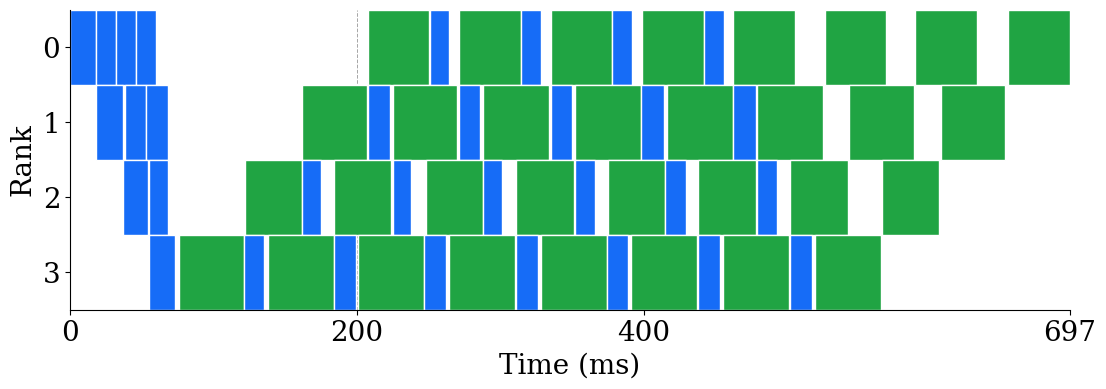

✅ Pipeline schedule is saved as: 260103_0150_final2000_rank3_clear.svg
> Batch Time: 697.00 ms, GPU Bubble Ratio: 34.29%, 29.70%, 38.16%, 29.84%


In [38]:
input_str = '''
[rank3]:2026-01-03 01:50:06,942 - ✅ Pipeline schedule is saved as: /opt/dlami/nvme/DMLAB/shcho/torchtitan_data/images/260102_1F1B_nofreeze_h200/pipeline_schedule/260103_0150_final2000_rank3.svg
[rank3]:			> Batch Time: 697.06 ms, GPU Bubble Ratio: 33.77%, 28.75%, 37.07%, 29.13%
[rank3]:			  [Rank 0]	[S0,MB0,F]  0-18-18ms      | [S0,MB1,F]  18-14-32ms     | [S0,MB2,F]  32-14-46ms     | [S0,MB3,F]  46-14-60ms     | [S0,MB0,B]  208-42-251ms   | [S0,MB4,F]  251-13-265ms   | [S0,MB1,B]  271-43-314ms   | [S0,MB5,F]  314-14-328ms   | [S0,MB2,B]  335-43-378ms   | [S0,MB6,F]  378-14-392ms   | [S0,MB3,B]  399-43-442ms   | [S0,MB7,F]  442-14-456ms   | [S0,MB4,B]  462-43-505ms   | [S0,MB5,B]  526-43-569ms   | [S0,MB6,B]  589-43-632ms   | [S0,MB7,B]  654-43-697ms  
[rank3]:			  [Rank 1]	[S1,MB0,F]  18-19-37ms     | [S1,MB1,F]  38-15-53ms     | [S1,MB2,F]  53-15-69ms     | [S1,MB0,B]  162-45-207ms   | [S1,MB3,F]  208-15-223ms   | [S1,MB1,B]  225-45-271ms   | [S1,MB4,F]  271-15-287ms   | [S1,MB2,B]  288-46-334ms   | [S1,MB5,F]  335-15-351ms   | [S1,MB3,B]  352-46-398ms   | [S1,MB6,F]  398-16-414ms   | [S1,MB4,B]  416-46-462ms   | [S1,MB7,F]  462-16-478ms   | [S1,MB5,B]  479-46-525ms   | [S1,MB6,B]  543-45-588ms   | [S1,MB7,B]  607-45-653ms  
[rank3]:			  [Rank 2]	[S2,MB0,F]  37-17-55ms     | [S2,MB1,F]  55-13-69ms     | [S2,MB0,B]  122-40-162ms   | [S2,MB2,F]  162-13-176ms   | [S2,MB1,B]  184-40-225ms   | [S2,MB3,F]  225-13-239ms   | [S2,MB2,B]  248-40-288ms   | [S2,MB4,F]  288-13-302ms   | [S2,MB3,B]  311-40-352ms   | [S2,MB5,F]  352-14-366ms   | [S2,MB4,B]  375-40-415ms   | [S2,MB6,F]  415-14-429ms   | [S2,MB5,B]  438-40-479ms   | [S2,MB7,F]  479-14-493ms   | [S2,MB6,B]  502-40-542ms   | [S2,MB7,B]  566-40-606ms  
[rank3]:			  [Rank 3]	[S3,MB0,F]  55-18-74ms     | [S3,MB0,B]  76-45-121ms    | [S3,MB1,F]  121-14-136ms   | [S3,MB1,B]  138-46-184ms   | [S3,MB2,F]  184-15-199ms   | [S3,MB2,B]  201-46-247ms   | [S3,MB3,F]  247-15-262ms   | [S3,MB3,B]  264-46-311ms   | [S3,MB4,F]  311-15-326ms   | [S3,MB4,B]  328-46-374ms   | [S3,MB5,F]  374-15-389ms   | [S3,MB5,B]  391-46-438ms   | [S3,MB6,F]  438-15-453ms   | [S3,MB6,B]  455-46-501ms   | [S3,MB7,F]  502-15-517ms   | [S3,MB7,B]  519-46-565ms  
'''
save_file, pipeline_schedule = parse_pipeline_schedule_log(input_str)
print("save_file:", save_file)
print("ranks:", len(pipeline_schedule))
print("actions per rank:", [len(r) for r in pipeline_schedule])
draw_pipeline_schedule(
    save_file=save_file[:-4]+'_clear.svg', 
    pipeline_schedule=pipeline_schedule,
    tick_unit=200)